# ViT CIFAR-10
load timm ViT and retrain on CIFAR 10

In [1]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import network.resnet_orig as resnet

import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 224

In [2]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [3]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [4]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

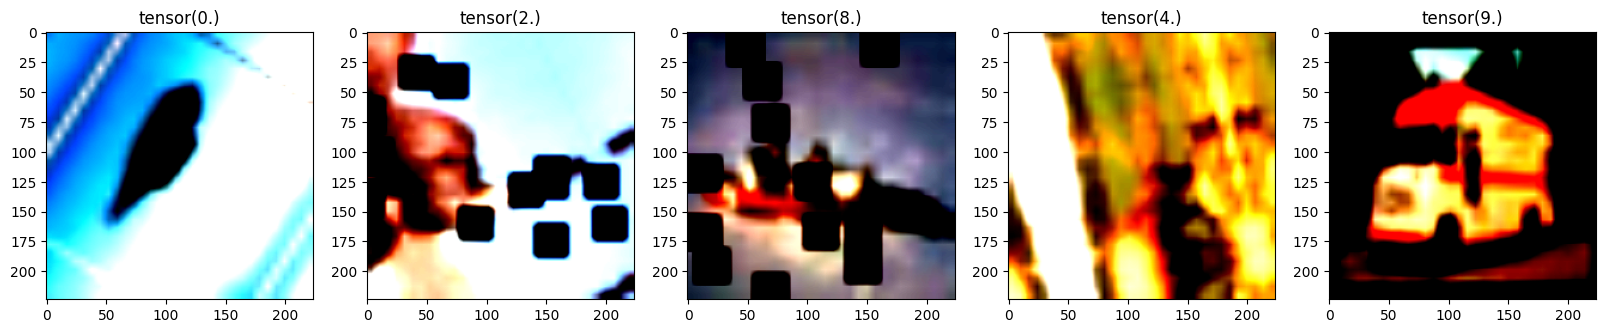

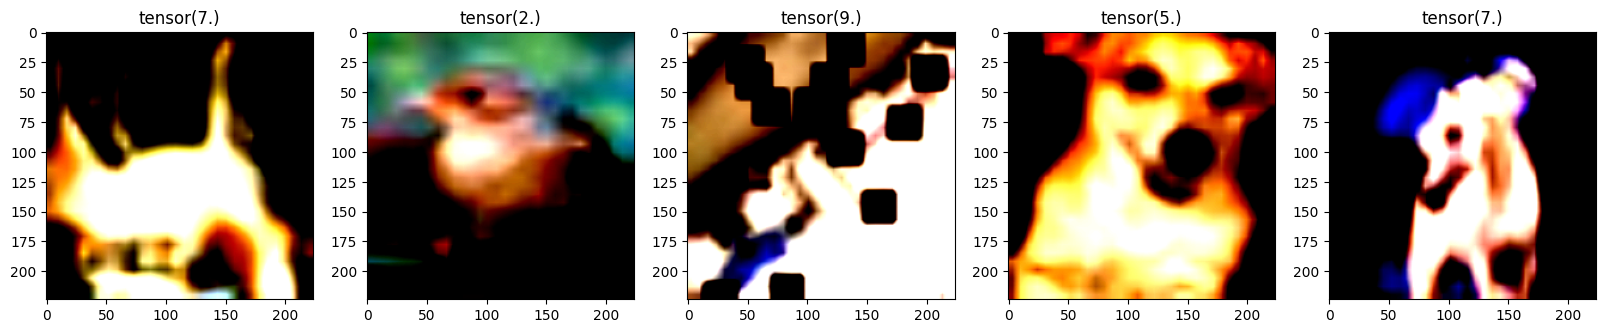

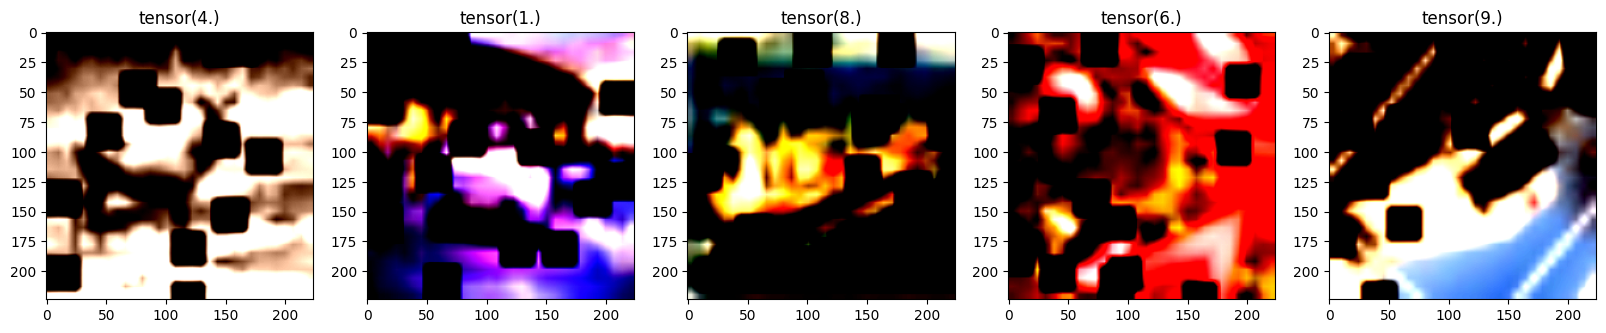

In [5]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [6]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [7]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512, shuffle=False,
    num_workers=4, pin_memory=True)

In [8]:
import timm
net = timm.create_model("vit_small_patch16_224", pretrained=True)
net.head = nn.Linear(net.head.in_features, 10)

model = net.cuda()
mixup = False

import wandb
watermark = "vit_small_noquant"
wandb.init(project="pact_vit",
            name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                            momentum=0.9,
                            weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=[80, 150],)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

for epoch in range(3):
    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    tloss = train(train_loader, model, criterion, optimizer, epoch)
    lr_scheduler.step()

    # evaluate on validation set
    prec1, valloss = validate(val_loader, model, criterion)

    # wandb
    wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Best prec1 : ", best_prec1)
    if is_best:
        torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

# Train with quantization

In [9]:
"""PyTorch ResNet
This started as a copy of https://github.com/pytorch/vision 'resnet.py' (BSD-3-Clause) with
additional dropout and dynamic global avg/max pool.
ResNeXt, SE-ResNeXt, SENet, and MXNet Gluon stem/downsample variants, tiered stems added by Ross Wightman
Copyright 2020 Ross Wightman
"""
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import build_model_with_cfg
from timm.models.layers import DropBlock2d, DropPath, AvgPool2dSame, BlurPool2d, create_attn, get_attn, create_classifier
from timm.models.registry import register_model

from module import DoReFaQuant, ActFn

class Conv2d(nn.Conv2d):
	def __init__(self, in_places, out_planes, kernel_size, stride=1, padding = 0, groups=1, dilation=1, bias = False, k = 8, noise = 0, inference=False):
		super(Conv2d, self).__init__(in_places, out_planes, kernel_size, stride, padding, groups, dilation, bias)
		self.quantize = DoReFaQuant.apply
		self.bitwidth = k

	def forward(self, x):
		vhat = self.quantize(self.weight, self.bitwidth)
		y = F.conv2d(x, vhat, self.bias, self.stride, self.padding, self.dilation, self.groups)
		#y = self.noise(y)
		return y

__all__ = ['ResNet', 'BasicBlock', 'Bottleneck']  # model_registry will add each entrypoint fn to this


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': (7, 7),
        'crop_pct': 0.875, 'interpolation': 'bilinear',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'conv1', 'classifier': 'fc',
        **kwargs
    }


default_cfgs = {
    # ResNet and Wide ResNet
    'resnet18': _cfg(url='https://download.pytorch.org/models/resnet18-5c106cde.pth'),
    'resnet18d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth',
        interpolation='bicubic', first_conv='conv1.0'),
    'resnet34': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth'),
    'resnet34d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34d_ra2-f8dcfcaf.pth',
        interpolation='bicubic', first_conv='conv1.0'),
    'resnet26': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26-9aa10e23.pth',
        interpolation='bicubic'),
    'resnet26d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth',
        interpolation='bicubic', first_conv='conv1.0'),
    'resnet26t': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/resnet26t_256_ra2-6f6fa748.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8)),
    'resnet50': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-00ca2c6a.pth',
        interpolation='bicubic'),
    'resnet50d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth',
        interpolation='bicubic', first_conv='conv1.0', crop_pct=0.95),
    'resnet50t': _cfg(
        url='',
        interpolation='bicubic', first_conv='conv1.0'),
    'resnet101': _cfg(url='', interpolation='bicubic'),
    'resnet101d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet101d_ra2-2803ffab.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8),
        crop_pct=1.0, test_input_size=(3, 320, 320)),
    'resnet152': _cfg(url='', interpolation='bicubic'),
    'resnet152d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet152d_ra2-5cac0439.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8),
        crop_pct=1.0, test_input_size=(3, 320, 320)),
    'resnet200': _cfg(url='', interpolation='bicubic'),
    'resnet200d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet200d_ra2-bdba9bf9.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8),
        crop_pct=1.0, test_input_size=(3, 320, 320)),
    'tv_resnet34': _cfg(url='https://download.pytorch.org/models/resnet34-333f7ec4.pth'),
    'tv_resnet50': _cfg(url='https://download.pytorch.org/models/resnet50-19c8e357.pth'),
    'tv_resnet101': _cfg(url='https://download.pytorch.org/models/resnet101-5d3b4d8f.pth'),
    'tv_resnet152': _cfg(url='https://download.pytorch.org/models/resnet152-b121ed2d.pth'),
    'wide_resnet50_2': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/wide_resnet50_racm-8234f177.pth',
        interpolation='bicubic'),
    'wide_resnet101_2': _cfg(url='https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth'),

    # ResNeXt
    'resnext50_32x4d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth',
        interpolation='bicubic'),
    'resnext50d_32x4d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50d_32x4d-103e99f8.pth',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'resnext101_32x4d': _cfg(url=''),
    'resnext101_32x8d': _cfg(url='https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth'),
    'resnext101_64x4d': _cfg(url=''),
    'tv_resnext50_32x4d': _cfg(url='https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth'),

    #  ResNeXt models - Weakly Supervised Pretraining on Instagram Hashtags
    #  from https://github.com/facebookresearch/WSL-Images
    #  Please note the CC-BY-NC 4.0 license on theses weights, non-commercial use only.
    'ig_resnext101_32x8d': _cfg(url='https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth'),
    'ig_resnext101_32x16d': _cfg(url='https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth'),
    'ig_resnext101_32x32d': _cfg(url='https://download.pytorch.org/models/ig_resnext101_32x32-e4b90b00.pth'),
    'ig_resnext101_32x48d': _cfg(url='https://download.pytorch.org/models/ig_resnext101_32x48-3e41cc8a.pth'),

    #  Semi-Supervised ResNe*t models from https://github.com/facebookresearch/semi-supervised-ImageNet1K-models
    #  Please note the CC-BY-NC 4.0 license on theses weights, non-commercial use only.
    'ssl_resnet18':  _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnet18-d92f0530.pth'),
    'ssl_resnet50':  _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnet50-08389792.pth'),
    'ssl_resnext50_32x4d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth'),
    'ssl_resnext101_32x4d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x4-dc43570a.pth'),
    'ssl_resnext101_32x8d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x8-2cfe2f8b.pth'),
    'ssl_resnext101_32x16d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x16-15fffa57.pth'),

    #  Semi-Weakly Supervised ResNe*t models from https://github.com/facebookresearch/semi-supervised-ImageNet1K-models
    #  Please note the CC-BY-NC 4.0 license on theses weights, non-commercial use only.
    'swsl_resnet18': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet18-118f1556.pth'),
    'swsl_resnet50': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet50-16a12f1b.pth'),
    'swsl_resnext50_32x4d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext50_32x4-72679e44.pth'),
    'swsl_resnext101_32x4d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext101_32x4-3f87e46b.pth'),
    'swsl_resnext101_32x8d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext101_32x8-b4712904.pth'),
    'swsl_resnext101_32x16d': _cfg(
        url='https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext101_32x16-f3559a9c.pth'),

    #  Squeeze-Excitation ResNets, to eventually replace the models in senet.py
    'seresnet18': _cfg(
        url='',
        interpolation='bicubic'),
    'seresnet34': _cfg(
        url='',
        interpolation='bicubic'),
    'seresnet50': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnet50_ra_224-8efdb4bb.pth',
        interpolation='bicubic'),
    'seresnet50t': _cfg(
        url='',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'seresnet101': _cfg(
        url='',
        interpolation='bicubic'),
    'seresnet152': _cfg(
        url='',
        interpolation='bicubic'),
    'seresnet152d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnet152d_ra2-04464dd2.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8),
        crop_pct=1.0, test_input_size=(3, 320, 320)
    ),
    'seresnet200d': _cfg(
        url='',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), crop_pct=0.94, pool_size=(8, 8)),
    'seresnet269d': _cfg(
        url='',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), crop_pct=0.94, pool_size=(8, 8)),


    #  Squeeze-Excitation ResNeXts, to eventually replace the models in senet.py
    'seresnext26d_32x4d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext26d_32x4d-80fa48a3.pth',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'seresnext26t_32x4d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext26tn_32x4d-569cb627.pth',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'seresnext50_32x4d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth',
        interpolation='bicubic'),
    'seresnext101_32x4d': _cfg(
        url='',
        interpolation='bicubic'),
    'seresnext101_32x8d': _cfg(
        url='',
        interpolation='bicubic'),
    'senet154': _cfg(
        url='',
        interpolation='bicubic',
        first_conv='conv1.0'),

    # Efficient Channel Attention ResNets
    'ecaresnet26t': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecaresnet26t_ra2-46609757.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8),
        crop_pct=0.95, test_input_size=(3, 320, 320)),
    'ecaresnetlight': _cfg(
        url='https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45402/outputs/ECAResNetLight_4f34b35b.pth',
        interpolation='bicubic'),
    'ecaresnet50d': _cfg(
        url='https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45402/outputs/ECAResNet50D_833caf58.pth',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'ecaresnet50d_pruned': _cfg(
        url='https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45899/outputs/ECAResNet50D_P_9c67f710.pth',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'ecaresnet50t': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecaresnet50t_ra2-f7ac63c4.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), pool_size=(8, 8),
        crop_pct=0.95, test_input_size=(3, 320, 320)),
    'ecaresnet101d': _cfg(
        url='https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45402/outputs/ECAResNet101D_281c5844.pth',
        interpolation='bicubic', first_conv='conv1.0'),
    'ecaresnet101d_pruned': _cfg(
        url='https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45610/outputs/ECAResNet101D_P_75a3370e.pth',
        interpolation='bicubic',
        first_conv='conv1.0'),
    'ecaresnet200d': _cfg(
        url='',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 256, 256), crop_pct=0.94, pool_size=(8, 8)),
    'ecaresnet269d': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/ecaresnet269d_320_ra2-7baa55cb.pth',
        interpolation='bicubic', first_conv='conv1.0', input_size=(3, 320, 320), pool_size=(10, 10),
        crop_pct=1.0, test_input_size=(3, 352, 352)),

    # Efficient Channel Attention ResNeXts
    'ecaresnext26t_32x4d': _cfg(
        url='',
        interpolation='bicubic', first_conv='conv1.0'),
    'ecaresnext50t_32x4d': _cfg(
        url='',
        interpolation='bicubic', first_conv='conv1.0'),

    # ResNets with anti-aliasing blur pool
    'resnetblur18': _cfg(
        interpolation='bicubic'),
    'resnetblur50': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnetblur50-84f4748f.pth',
        interpolation='bicubic'),

    # ResNet-RS models
    'resnetrs50': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs50_ema-6b53758b.pth',
        input_size=(3, 160, 160), pool_size=(5, 5), crop_pct=0.91, test_input_size=(3, 224, 224),
        interpolation='bicubic', first_conv='conv1.0'),
    'resnetrs101': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs101_i192_ema-1509bbf6.pth',
        input_size=(3, 192, 192), pool_size=(6, 6), crop_pct=0.94, test_input_size=(3, 288, 288),
        interpolation='bicubic', first_conv='conv1.0'),
    'resnetrs152': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs152_i256_ema-a9aff7f9.pth',
        input_size=(3, 256, 256), pool_size=(8, 8), crop_pct=1.0, test_input_size=(3, 320, 320),
        interpolation='bicubic', first_conv='conv1.0'),
    'resnetrs200': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs200_ema-623d2f59.pth',
        input_size=(3, 256, 256), pool_size=(8, 8), crop_pct=1.0, test_input_size=(3, 320, 320),
        interpolation='bicubic', first_conv='conv1.0'),
    'resnetrs270': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs270_ema-b40e674c.pth',
        input_size=(3, 256, 256), pool_size=(8, 8), crop_pct=1.0, test_input_size=(3, 352, 352),
        interpolation='bicubic', first_conv='conv1.0'),
    'resnetrs350': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs350_i256_ema-5a1aa8f1.pth',
        input_size=(3, 288, 288), pool_size=(9, 9), crop_pct=1.0, test_input_size=(3, 384, 384),
        interpolation='bicubic', first_conv='conv1.0'),
    'resnetrs420': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rs-weights/resnetrs420_ema-972dee69.pth',
        input_size=(3, 320, 320), pool_size=(10, 10), crop_pct=1.0, test_input_size=(3, 416, 416),
        interpolation='bicubic', first_conv='conv1.0'),
}


def get_padding(kernel_size, stride, dilation=1):
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, cardinality=1, base_width=64,
                 reduce_first=1, dilation=1, first_dilation=None, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d,
                 attn_layer=None, aa_layer=None, drop_block=None, drop_path=None, k=8):
        super(BasicBlock, self).__init__()

        assert cardinality == 1, 'BasicBlock only supports cardinality of 1'
        assert base_width == 64, 'BasicBlock does not support changing base width'
        first_planes = planes // reduce_first
        outplanes = planes * self.expansion
        first_dilation = first_dilation or dilation
        use_aa = aa_layer is not None and (stride == 2 or first_dilation != dilation)

        self.conv1 = Conv2d(
            inplanes, first_planes, kernel_size=3, stride=1 if use_aa else stride, padding=first_dilation,
            dilation=first_dilation, bias=False, k=k)
        self.bn1 = norm_layer(first_planes)
        self.act1 = act_layer(inplace=True)
        self.aa = aa_layer(channels=first_planes, stride=stride) if use_aa else None
        # PACT Quantization
        self.alpha1 = nn.Parameter(torch.tensor(2.))
        self.alpha2 = nn.Parameter(torch.tensor(2.))
        self.quant = ActFn.apply
        self.k = k

        self.conv2 = Conv2d(
            first_planes, outplanes, kernel_size=3, padding=dilation, dilation=dilation, bias=False, k=k)
        self.bn2 = norm_layer(outplanes)

        self.se = create_attn(attn_layer, outplanes)

        self.act2 = act_layer(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn2.weight)

    def forward(self, x):
        shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)
        if self.aa is not None:
            x = self.aa(x)
        x = self.quant(x, self.alpha1, self.k)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.se is not None:
            x = self.se(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.downsample is not None:
            shortcut = self.downsample(shortcut)
        x += shortcut
        x = self.act2(x)
        x = self.quant(x, self.alpha2, self.k)

        return x


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, cardinality=1, base_width=64,
                 reduce_first=1, dilation=1, first_dilation=None, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d,
                 attn_layer=None, aa_layer=None, drop_block=None, drop_path=None, k=8):
        super(Bottleneck, self).__init__()

        width = int(math.floor(planes * (base_width / 64)) * cardinality)
        first_planes = width // reduce_first
        outplanes = planes * self.expansion
        first_dilation = first_dilation or dilation
        use_aa = aa_layer is not None and (stride == 2 or first_dilation != dilation)

        self.conv1 = Conv2d(inplanes, first_planes, kernel_size=1, bias=False, k=k)
        self.bn1 = norm_layer(first_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(
            first_planes, width, kernel_size=3, stride=1 if use_aa else stride,
            padding=first_dilation, dilation=first_dilation, groups=cardinality, bias=False)
        self.bn2 = norm_layer(width)
        self.act2 = act_layer(inplace=True)
        self.aa = aa_layer(channels=width, stride=stride) if use_aa else None

        self.conv3 = Conv2d(width, outplanes, kernel_size=1, bias=False, k=k)
        self.bn3 = norm_layer(outplanes)

        self.se = create_attn(attn_layer, outplanes)

        self.act3 = act_layer(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x):
        shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act2(x)
        if self.aa is not None:
            x = self.aa(x)

        x = self.conv3(x)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.se is not None:
            x = self.se(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.downsample is not None:
            shortcut = self.downsample(shortcut)
        x += shortcut
        x = self.act3(x)

        return x


def downsample_conv(
        in_channels, out_channels, kernel_size, stride=1, dilation=1, first_dilation=None, norm_layer=None):
    norm_layer = norm_layer or nn.BatchNorm2d
    kernel_size = 1 if stride == 1 and dilation == 1 else kernel_size
    first_dilation = (first_dilation or dilation) if kernel_size > 1 else 1
    p = get_padding(kernel_size, stride, first_dilation)

    return nn.Sequential(*[
        nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=stride, padding=p, dilation=first_dilation, bias=False),
        norm_layer(out_channels)
    ])


def downsample_avg(
        in_channels, out_channels, kernel_size, stride=1, dilation=1, first_dilation=None, norm_layer=None):
    norm_layer = norm_layer or nn.BatchNorm2d
    avg_stride = stride if dilation == 1 else 1
    if stride == 1 and dilation == 1:
        pool = nn.Identity()
    else:
        avg_pool_fn = AvgPool2dSame if avg_stride == 1 and dilation > 1 else nn.AvgPool2d
        pool = avg_pool_fn(2, avg_stride, ceil_mode=True, count_include_pad=False)

    return nn.Sequential(*[
        pool,
        nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        norm_layer(out_channels)
    ])


def drop_blocks(drop_block_rate=0.):
    return [
        None, None,
        DropBlock2d(drop_block_rate, 5, 0.25) if drop_block_rate else None,
        DropBlock2d(drop_block_rate, 3, 1.00) if drop_block_rate else None]


def make_blocks(
        block_fn, channels, block_repeats, inplanes, reduce_first=1, output_stride=32,
        down_kernel_size=1, avg_down=False, drop_block_rate=0., drop_path_rate=0., k=8, **kwargs):
    stages = []
    feature_info = []
    net_num_blocks = sum(block_repeats)
    net_block_idx = 0
    net_stride = 4
    dilation = prev_dilation = 1
    for stage_idx, (planes, num_blocks, db) in enumerate(zip(channels, block_repeats, drop_blocks(drop_block_rate))):
        stage_name = f'layer{stage_idx + 1}'  # never liked this name, but weight compat requires it
        stride = 1 if stage_idx == 0 else 2
        if net_stride >= output_stride:
            dilation *= stride
            stride = 1
        else:
            net_stride *= stride

        downsample = None
        if stride != 1 or inplanes != planes * block_fn.expansion:
            down_kwargs = dict(
                in_channels=inplanes, out_channels=planes * block_fn.expansion, kernel_size=down_kernel_size,
                stride=stride, dilation=dilation, first_dilation=prev_dilation, norm_layer=kwargs.get('norm_layer'))
            downsample = downsample_avg(**down_kwargs) if avg_down else downsample_conv(**down_kwargs)

        block_kwargs = dict(reduce_first=reduce_first, dilation=dilation, drop_block=db, **kwargs)
        blocks = []
        for block_idx in range(num_blocks):
            downsample = downsample if block_idx == 0 else None
            stride = stride if block_idx == 0 else 1
            block_dpr = drop_path_rate * net_block_idx / (net_num_blocks - 1)  # stochastic depth linear decay rule
            blocks.append(block_fn(
                inplanes, planes, stride, downsample, first_dilation=prev_dilation,
                drop_path=DropPath(block_dpr) if block_dpr > 0. else None, k=k, **block_kwargs))
            prev_dilation = dilation
            inplanes = planes * block_fn.expansion
            net_block_idx += 1

        stages.append((stage_name, nn.Sequential(*blocks)))
        feature_info.append(dict(num_chs=inplanes, reduction=net_stride, module=stage_name))

    return stages, feature_info


class ResNet(nn.Module):
    """ResNet / ResNeXt / SE-ResNeXt / SE-Net
    This class implements all variants of ResNet, ResNeXt, SE-ResNeXt, and SENet that
      * have > 1 stride in the 3x3 conv layer of bottleneck
      * have conv-bn-act ordering
    This ResNet impl supports a number of stem and downsample options based on the v1c, v1d, v1e, and v1s
    variants included in the MXNet Gluon ResNetV1b model. The C and D variants are also discussed in the
    'Bag of Tricks' paper: https://arxiv.org/pdf/1812.01187. The B variant is equivalent to torchvision default.
    ResNet variants (the same modifications can be used in SE/ResNeXt models as well):
      * normal, b - 7x7 stem, stem_width = 64, same as torchvision ResNet, NVIDIA ResNet 'v1.5', Gluon v1b
      * c - 3 layer deep 3x3 stem, stem_width = 32 (32, 32, 64)
      * d - 3 layer deep 3x3 stem, stem_width = 32 (32, 32, 64), average pool in downsample
      * e - 3 layer deep 3x3 stem, stem_width = 64 (64, 64, 128), average pool in downsample
      * s - 3 layer deep 3x3 stem, stem_width = 64 (64, 64, 128)
      * t - 3 layer deep 3x3 stem, stem width = 32 (24, 48, 64), average pool in downsample
      * tn - 3 layer deep 3x3 stem, stem width = 32 (24, 32, 64), average pool in downsample
    ResNeXt
      * normal - 7x7 stem, stem_width = 64, standard cardinality and base widths
      * same c,d, e, s variants as ResNet can be enabled
    SE-ResNeXt
      * normal - 7x7 stem, stem_width = 64
      * same c, d, e, s variants as ResNet can be enabled
    SENet-154 - 3 layer deep 3x3 stem (same as v1c-v1s), stem_width = 64, cardinality=64,
        reduction by 2 on width of first bottleneck convolution, 3x3 downsample convs after first block
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockGl, BottleneckGl.
    layers : list of int
        Numbers of layers in each block
    num_classes : int, default 1000
        Number of classification classes.
    in_chans : int, default 3
        Number of input (color) channels.
    cardinality : int, default 1
        Number of convolution groups for 3x3 conv in Bottleneck.
    base_width : int, default 64
        Factor determining bottleneck channels. `planes * base_width / 64 * cardinality`
    stem_width : int, default 64
        Number of channels in stem convolutions
    stem_type : str, default ''
        The type of stem:
          * '', default - a single 7x7 conv with a width of stem_width
          * 'deep' - three 3x3 convolution layers of widths stem_width, stem_width, stem_width * 2
          * 'deep_tiered' - three 3x3 conv layers of widths stem_width//4 * 3, stem_width, stem_width * 2
    block_reduce_first: int, default 1
        Reduction factor for first convolution output width of residual blocks,
        1 for all archs except senets, where 2
    down_kernel_size: int, default 1
        Kernel size of residual block downsampling path, 1x1 for most archs, 3x3 for senets
    avg_down : bool, default False
        Whether to use average pooling for projection skip connection between stages/downsample.
    output_stride : int, default 32
        Set the output stride of the network, 32, 16, or 8. Typically used in segmentation.
    act_layer : nn.Module, activation layer
    norm_layer : nn.Module, normalization layer
    aa_layer : nn.Module, anti-aliasing layer
    drop_rate : float, default 0.
        Dropout probability before classifier, for training
    global_pool : str, default 'avg'
        Global pooling type. One of 'avg', 'max', 'avgmax', 'catavgmax'
    """

    def __init__(self, block, layers, num_classes=1000, in_chans=3,
                 cardinality=1, base_width=64, stem_width=64, stem_type='', replace_stem_pool=False,
                 output_stride=32, block_reduce_first=1, down_kernel_size=1, avg_down=False,
                 act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d, aa_layer=None, drop_rate=0.0, drop_path_rate=0.,
                 drop_block_rate=0., global_pool='avg', zero_init_last_bn=True, block_args=None, k=8):
        block_args = block_args or dict()
        assert output_stride in (8, 16, 32)
        self.num_classes = num_classes
        self.drop_rate = drop_rate
        super(ResNet, self).__init__()

        # Stem
        deep_stem = 'deep' in stem_type
        inplanes = stem_width * 2 if deep_stem else 64
        if deep_stem:
            stem_chs = (stem_width, stem_width)
            if 'tiered' in stem_type:
                stem_chs = (3 * (stem_width // 4), stem_width)
            self.conv1 = nn.Sequential(*[
                nn.Conv2d(in_chans, stem_chs[0], 3, stride=2, padding=1, bias=False),
                norm_layer(stem_chs[0]),
                act_layer(inplace=True),
                nn.Conv2d(stem_chs[0], stem_chs[1], 3, stride=1, padding=1, bias=False),
                norm_layer(stem_chs[1]),
                act_layer(inplace=True),
                nn.Conv2d(stem_chs[1], inplanes, 3, stride=1, padding=1, bias=False)])
        else:
            self.conv1 = nn.Conv2d(in_chans, inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(inplanes)
        self.act1 = act_layer(inplace=True)
        self.feature_info = [dict(num_chs=inplanes, reduction=2, module='act1')]

        # Stem Pooling
        if replace_stem_pool:
            self.maxpool = nn.Sequential(*filter(None, [
                nn.Conv2d(inplanes, inplanes, 3, stride=1 if aa_layer else 2, padding=1, bias=False),
                aa_layer(channels=inplanes, stride=2) if aa_layer else None,
                norm_layer(inplanes),
                act_layer(inplace=True)
            ]))
        else:
            if aa_layer is not None:
                self.maxpool = nn.Sequential(*[
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    aa_layer(channels=inplanes, stride=2)])
            else:
                self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Feature Blocks
        channels = [64, 128, 256, 512]
        stage_modules, stage_feature_info = make_blocks(
            block, channels, layers, inplanes, cardinality=cardinality, base_width=base_width,
            output_stride=output_stride, reduce_first=block_reduce_first, avg_down=avg_down,
            down_kernel_size=down_kernel_size, act_layer=act_layer, norm_layer=norm_layer, aa_layer=aa_layer,
            drop_block_rate=drop_block_rate, drop_path_rate=drop_path_rate, k=k, **block_args)
        for stage in stage_modules:
            self.add_module(*stage)  # layer1, layer2, etc
        self.feature_info.extend(stage_feature_info)

        # Head (Pooling and Classifier)
        self.num_features = 512 * block.expansion
        self.global_pool, self.fc = create_classifier(self.num_features, self.num_classes, pool_type=global_pool)

        self.init_weights(zero_init_last_bn=zero_init_last_bn)

    def init_weights(self, zero_init_last_bn=True):
        for n, m in self.named_modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
        if zero_init_last_bn:
            for m in self.modules():
                if hasattr(m, 'zero_init_last_bn'):
                    m.zero_init_last_bn()

    def get_classifier(self):
        return self.fc

    def reset_classifier(self, num_classes, global_pool='avg'):
        self.num_classes = num_classes
        self.global_pool, self.fc = create_classifier(self.num_features, self.num_classes, pool_type=global_pool)

    def forward_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.global_pool(x)
        if self.drop_rate:
            x = F.dropout(x, p=float(self.drop_rate), training=self.training)
        x = self.fc(x)
        return x


def _create_resnet(variant, pretrained=False, k=8, **kwargs):
    return build_model_with_cfg(
        ResNet, variant, pretrained,
        default_cfg=default_cfgs[variant], k=k,
        **kwargs)

@register_model
def resnet18(pretrained=False, k=8, **kwargs):
    """Constructs a ResNet-18 model.
    """
    model_args = dict(block=BasicBlock, layers=[2, 2, 2, 2], k=k, **kwargs)
    return _create_resnet('resnet18', pretrained, **model_args)

In [12]:
k=3
net = resnet18(True, k=k, pretrained_strict=False)
net.fc = nn.Linear(net.fc.in_features, 10)
#checkpoint = torch.load("models/vit_small_noquant.pth")
#net.load_state_dict(checkpoint, strict=True)

In [13]:
model = net.cuda()
mixup = False

# Track experiment with wandb
import wandb
watermark = "resnet18_timm_k{}".format(k)
wandb.init(project="pact_vit", name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

# optimizer for pact
# 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                            momentum=0.9,
                            weight_decay=0.0002)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=[10],)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

for epoch in range(20):
    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    tloss = train(train_loader, model, criterion, optimizer, epoch)
    lr_scheduler.step()

    # evaluate on validation set
    prec1, valloss = validate(val_loader, model, criterion)

    # wandb
    wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    print("Best prec1 : ", best_prec1)
    if is_best:
        torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

epoch,19
lr,1e-05
prec,94.51
train_loss,0.37208
val_loss,0.16399


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,█████████▁▁▁▁▁▁▁▁▁▁▁
prec,▁▃▅▄▅▆▆▆▇▇██████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


current lr 1.00000e-04
Epoch: [0][0/313]	Time 0.522 (0.522)	Data 0.391 (0.391)	Loss 2.5860 (2.5860)	Prec@1 7.031 (7.031)
Epoch: [0][50/313]	Time 0.129 (0.137)	Data 0.000 (0.008)	Loss 1.8380 (2.0955)	Prec@1 33.594 (26.808)
Epoch: [0][100/313]	Time 0.130 (0.133)	Data 0.000 (0.004)	Loss 1.7530 (1.9529)	Prec@1 40.625 (33.014)
Epoch: [0][150/313]	Time 0.131 (0.132)	Data 0.000 (0.003)	Loss 1.6716 (1.8530)	Prec@1 44.531 (37.215)
Epoch: [0][200/313]	Time 0.129 (0.131)	Data 0.000 (0.002)	Loss 1.5847 (1.7812)	Prec@1 45.312 (40.058)
Epoch: [0][250/313]	Time 0.129 (0.131)	Data 0.000 (0.002)	Loss 1.4609 (1.7265)	Prec@1 54.688 (42.163)
Epoch: [0][300/313]	Time 0.131 (0.131)	Data 0.000 (0.002)	Loss 1.5051 (1.6712)	Prec@1 49.219 (44.215)
Test: [0/20]	Time 1.127 (1.127)	Loss 0.8912 (0.8912)	Prec@1 69.336 (69.336)
 * Prec@1 67.400
layer1.0.alpha1 1.9691967964172363
layer1.0.alpha2 1.9739900827407837
layer1.1.alpha1 1.968951940536499
layer1.1.alpha2 1.9754091501235962
layer2.0.alpha1 1.9688130617141724
l

Epoch: [6][0/313]	Time 0.497 (0.497)	Data 0.353 (0.353)	Loss 0.7845 (0.7845)	Prec@1 74.219 (74.219)
Epoch: [6][50/313]	Time 0.131 (0.139)	Data 0.000 (0.007)	Loss 0.6994 (0.7764)	Prec@1 76.562 (76.823)
Epoch: [6][100/313]	Time 0.131 (0.135)	Data 0.000 (0.004)	Loss 0.7433 (0.7719)	Prec@1 74.219 (76.748)
Epoch: [6][150/313]	Time 0.132 (0.134)	Data 0.000 (0.003)	Loss 0.8300 (0.7702)	Prec@1 76.562 (76.671)
Epoch: [6][200/313]	Time 0.131 (0.133)	Data 0.000 (0.002)	Loss 0.5996 (0.7714)	Prec@1 85.938 (76.741)
Epoch: [6][250/313]	Time 0.131 (0.133)	Data 0.000 (0.002)	Loss 0.8734 (0.7704)	Prec@1 73.438 (76.777)
Epoch: [6][300/313]	Time 0.131 (0.132)	Data 0.000 (0.001)	Loss 0.7319 (0.7680)	Prec@1 78.125 (76.887)
Test: [0/20]	Time 1.218 (1.218)	Loss 0.3614 (0.3614)	Prec@1 88.281 (88.281)
 * Prec@1 86.260
layer1.0.alpha1 1.7871030569076538
layer1.0.alpha2 1.8433127403259277
layer1.1.alpha1 1.7857383489608765
layer1.1.alpha2 1.8783668279647827
layer2.0.alpha1 1.7855556011199951
layer2.0.alpha2 1.788

Epoch: [12][0/313]	Time 0.696 (0.696)	Data 0.399 (0.399)	Loss 0.5364 (0.5364)	Prec@1 86.719 (86.719)
Epoch: [12][50/313]	Time 0.298 (0.304)	Data 0.000 (0.008)	Loss 0.5805 (0.5541)	Prec@1 82.812 (84.406)
Epoch: [12][100/313]	Time 0.292 (0.299)	Data 0.000 (0.004)	Loss 0.6681 (0.5562)	Prec@1 81.250 (84.267)
Epoch: [12][150/313]	Time 0.298 (0.298)	Data 0.000 (0.003)	Loss 0.6377 (0.5518)	Prec@1 79.688 (84.411)
Epoch: [12][200/313]	Time 0.295 (0.297)	Data 0.000 (0.002)	Loss 0.6120 (0.5544)	Prec@1 79.688 (84.270)
Epoch: [12][250/313]	Time 0.286 (0.296)	Data 0.000 (0.002)	Loss 0.5232 (0.5521)	Prec@1 85.156 (84.291)
Epoch: [12][300/313]	Time 0.299 (0.287)	Data 0.000 (0.002)	Loss 0.6111 (0.5511)	Prec@1 82.031 (84.261)
Test: [0/20]	Time 7.012 (7.012)	Loss 0.2155 (0.2155)	Prec@1 92.578 (92.578)
 * Prec@1 91.160
layer1.0.alpha1 1.6889466047286987
layer1.0.alpha2 1.7802374362945557
layer1.1.alpha1 1.6870789527893066
layer1.1.alpha2 1.8336453437805176
layer2.0.alpha1 1.6866490840911865
layer2.0.alpha

Epoch: [18][0/313]	Time 0.634 (0.634)	Data 0.336 (0.336)	Loss 0.5223 (0.5223)	Prec@1 83.594 (83.594)
Epoch: [18][50/313]	Time 0.298 (0.302)	Data 0.000 (0.007)	Loss 0.5461 (0.5280)	Prec@1 84.375 (85.126)
Epoch: [18][100/313]	Time 0.298 (0.298)	Data 0.000 (0.004)	Loss 0.4815 (0.5305)	Prec@1 86.719 (85.110)
Epoch: [18][150/313]	Time 0.288 (0.297)	Data 0.000 (0.002)	Loss 0.5670 (0.5251)	Prec@1 85.938 (85.146)
Epoch: [18][200/313]	Time 0.298 (0.296)	Data 0.000 (0.002)	Loss 0.5252 (0.5278)	Prec@1 83.594 (85.148)
Epoch: [18][250/313]	Time 0.298 (0.291)	Data 0.000 (0.002)	Loss 0.4298 (0.5271)	Prec@1 88.281 (85.153)
Epoch: [18][300/313]	Time 0.295 (0.291)	Data 0.000 (0.001)	Loss 0.3839 (0.5250)	Prec@1 92.188 (85.250)
Test: [0/20]	Time 1.240 (1.240)	Loss 0.2148 (0.2148)	Prec@1 92.383 (92.383)
 * Prec@1 91.760
layer1.0.alpha1 1.670554280281067
layer1.0.alpha2 1.7693579196929932
layer1.1.alpha1 1.6686183214187622
layer1.1.alpha2 1.8255988359451294
layer2.0.alpha1 1.6681228876113892
layer2.0.alpha2